In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import lightgbm as lgbm
import optuna
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import seaborn as sns

# show all columns
pd.set_option('max_columns', None)

In [2]:
# read the data
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
sample = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

# drop id columns from train and test sets
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# Simple EDA

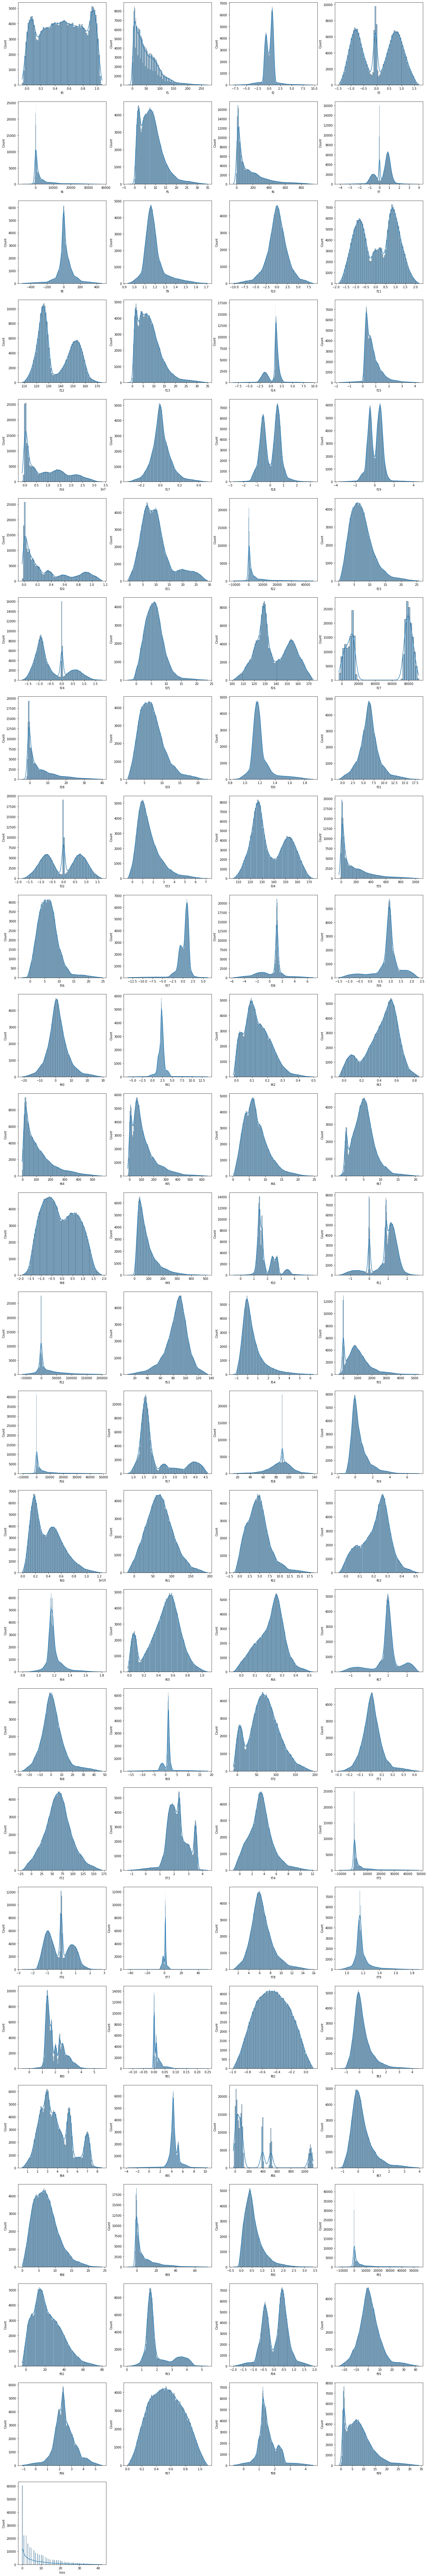

In [3]:
# histogramse for all variables with KDE
plt.figure(figsize=(24, 6*(104/4)))
for i in range(len(train.columns.tolist())):
    plt.subplot(26, 4, i+1)
    if i <= 99:
        sns.histplot(train[f'f{i}'], kde=True)
    else:
        sns.histplot(train['loss'], kde=True)
plt.show()

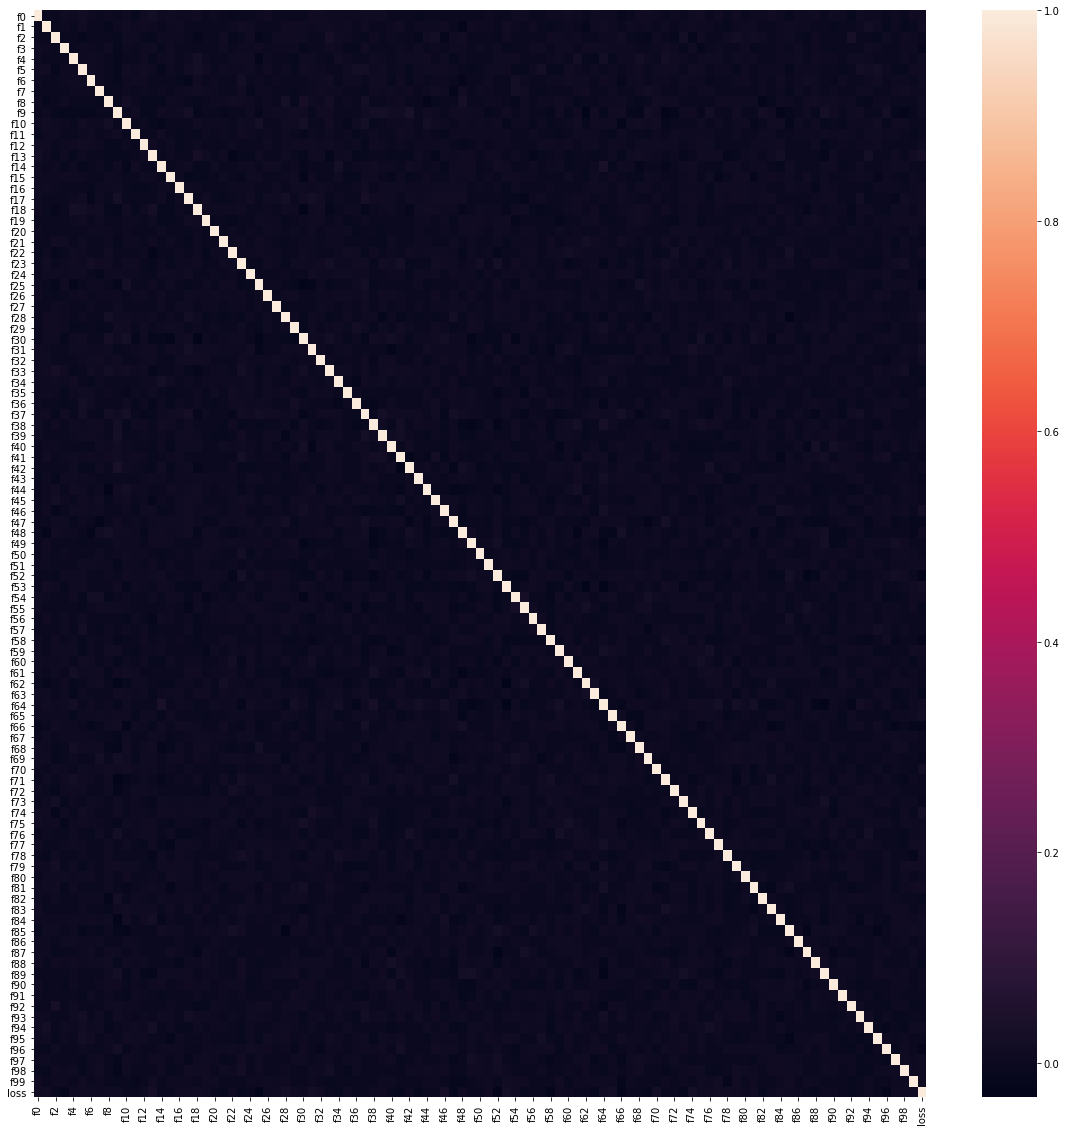

In [4]:
# correlation matrix with heat map
corr = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr)
plt.show()

In [5]:
# the ten highest correlated features for each feature
cols = train.columns.tolist()
for col in cols:
    print(col)
    print(corr[col].sort_values(ascending=False)[1:11])
    print('=======================')

f0
f13     0.016323
f83     0.013692
f75     0.013212
f5      0.012141
f26     0.011491
f18     0.011259
f68     0.010863
f99     0.010797
f69     0.010468
loss    0.008921
Name: f0, dtype: float64
f1
f94     0.018600
f64     0.015325
f10     0.014083
f53     0.013374
f5      0.012614
f23     0.012254
f41     0.011884
loss    0.011847
f49     0.011159
f74     0.011107
Name: f1, dtype: float64
f2
f92    0.028413
f33    0.026939
f79    0.019550
f45    0.016725
f73    0.016060
f44    0.013900
f81    0.013279
f21    0.013192
f48    0.012223
f66    0.011849
Name: f2, dtype: float64
f3
f37    0.013328
f15    0.009697
f33    0.009575
f71    0.008565
f62    0.008152
f25    0.008029
f94    0.007330
f8     0.006952
f56    0.006586
f21    0.006155
Name: f3, dtype: float64
f4
f18    0.021811
f64    0.018624
f71    0.018065
f68    0.016221
f61    0.015814
f34    0.013172
f44    0.011843
f72    0.010436
f12    0.010074
f88    0.008820
Name: f4, dtype: float64
f5
f95    0.019589
f57    0.018600
f37  

In [6]:
# extract X and y for training set
X = train.drop('loss', axis=1).values
y = train['loss'].values

# LightGBM with Optimized Hyperparameters

In [7]:
# optimized hyperparameters
params = {
        "min_child_weight": 638.7295413674256,
        "num_leaves": 32,
        "reg_alpha": 0.7635991288488166,
        "reg_lambda": 93.08626337603258
        }

# construct the model
model= lgbm.LGBMRegressor(
                       **params,
                       objective='rmse',
                       metric='rmse',
                       subsample=0.7,
                       learning_rate=0.03,
                       n_estimators=10000,
                       n_jobs=-1
                       )

# construct KFold cross validation
n_splits=5
kf = model_selection.KFold(n_splits=n_splits)

# initiate lists to save folds scores
scores_train = []
scores_valid = []

# initiate zeros array for test data predictions
preds_test_array = np.zeros((test.shape[0], ))

# KFold cross validation 
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):

    print(f"Fold {fold+1} -------------->")
    x_train, y_train = X[train_idx], y[train_idx]
    x_valid, y_valid = X[valid_idx], y[valid_idx]

    y_train_log = y_train
    y_valid_log = y_valid
    
    # fit the model
    model.fit(
            x_train, y_train_log,
            eval_set=[(x_valid,y_valid_log)],
            verbose=100,
            early_stopping_rounds=100
            )

    # clip the results so that the minimum and maximum values are 0 and 50, respectively
    preds_train = np.clip(model.predict(x_train), 0, 50)
    preds_valid = np.clip(model.predict(x_valid), 0, 50)
    preds_test = np.clip(model.predict(test), 0, 50)
    
    # add the predictions of each fold to the array
    preds_test_array += preds_test / n_splits
    
    # find both train and test rsme and observe if there is overfitting
    score_train = np.sqrt(metrics.mean_squared_error(y_train, preds_train))
    score_valid = np.sqrt(metrics.mean_squared_error(y_valid, preds_valid))
    
    # print the fold score
    print(score_valid)
    
    # append the fold score
    scores_train.append(score_train)
    scores_valid.append(score_valid)

print('Mean train score =', np.mean(scores_train), 'STD train =', np.std(scores_train, ddof=1))
print('Mean valid score =', np.mean(scores_valid), 'STD valid =', np.std(scores_valid, ddof=1))

# populate the submission dataframe
sample.iloc[:, 1] = preds_test_array
sample.to_csv('lgbm_base_model_submission.csv', index=False)

Fold 1 -------------->
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 7.85722
[200]	valid_0's rmse: 7.83703
[300]	valid_0's rmse: 7.8267
[400]	valid_0's rmse: 7.82208
[500]	valid_0's rmse: 7.81978
[600]	valid_0's rmse: 7.81809
[700]	valid_0's rmse: 7.8168
[800]	valid_0's rmse: 7.8167
Early stopping, best iteration is:
[791]	valid_0's rmse: 7.81651
7.816509965828737
Fold 2 -------------->
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 7.83931
[200]	valid_0's rmse: 7.82005
[300]	valid_0's rmse: 7.80966
[400]	valid_0's rmse: 7.805
[500]	valid_0's rmse: 7.80284
[600]	valid_0's rmse: 7.80128
[700]	valid_0's rmse: 7.80121
Early stopping, best iteration is:
[659]	valid_0's rmse: 7.80092
7.800920909238636
Fold 3 -------------->
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 7.91314
[200]	valid_0's rmse: 7.89083
[300]	valid_0's rmse: 7.87977
[400]	valid_0's rmse: 7.87496
[500]	valid_0'

Train and validation RMSE's are so close, hence the odds of overfitting is small.